<h1>SVM_ECC_ENSO_v3.1</h1>
<div>by Oscar Amarilla</div>

<p>This notebook orchestrates each step of an academic project that consists of applying a machine learning algorithm to the topologycal data analysys (TDA) of the mean sea surface temperature (SST) of a region of the central tropical Pacific.</p>

<h3>Importing modules, packages and data needed for the code</h3>

In [1]:
import numpy as np
import pandas as pd
from src import config
from src.extract import sst_fields, monthly_34_sst_avg 
from src.transform_and_load import TDA_process,ONI
from src.plots import *
from src.utils import *
from IPython.display import Image
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn import svm
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

<h2>1 - Extracting process</h2>
<p>The project needs two data, the first will be extracted from a netCDF file that contains the mean monthly SST from the period 1950-2021 from the region of interest defined by the coordinates (160ºE-270ºE,10ºN-10ºS), and the second is a csv file that contains data about the mean monthly SST of the Niño 3.4 region (170ºO-120ºO,5ºN-5ºS) of the same period of time.</p>
</br>
<p>The netCDF file containing the SST temperature can be adquired in the <a href='https://www.psl.noaa.gov/data/gridded/data.cobe.html'>Pysical Sciences Laboratory of the NOAA</a> and the data about the Niño 3.4 SST can be reached in the <a href='https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt'>Climate Prediction Center</a> of the same institution.</p>

In [2]:
sst = sst_fields(config.INPUT_DIR,config.FILES().nc_file)

<p>The following plot shows, in red, the region of the central tropical Pacific that is of interest for this project.</p>

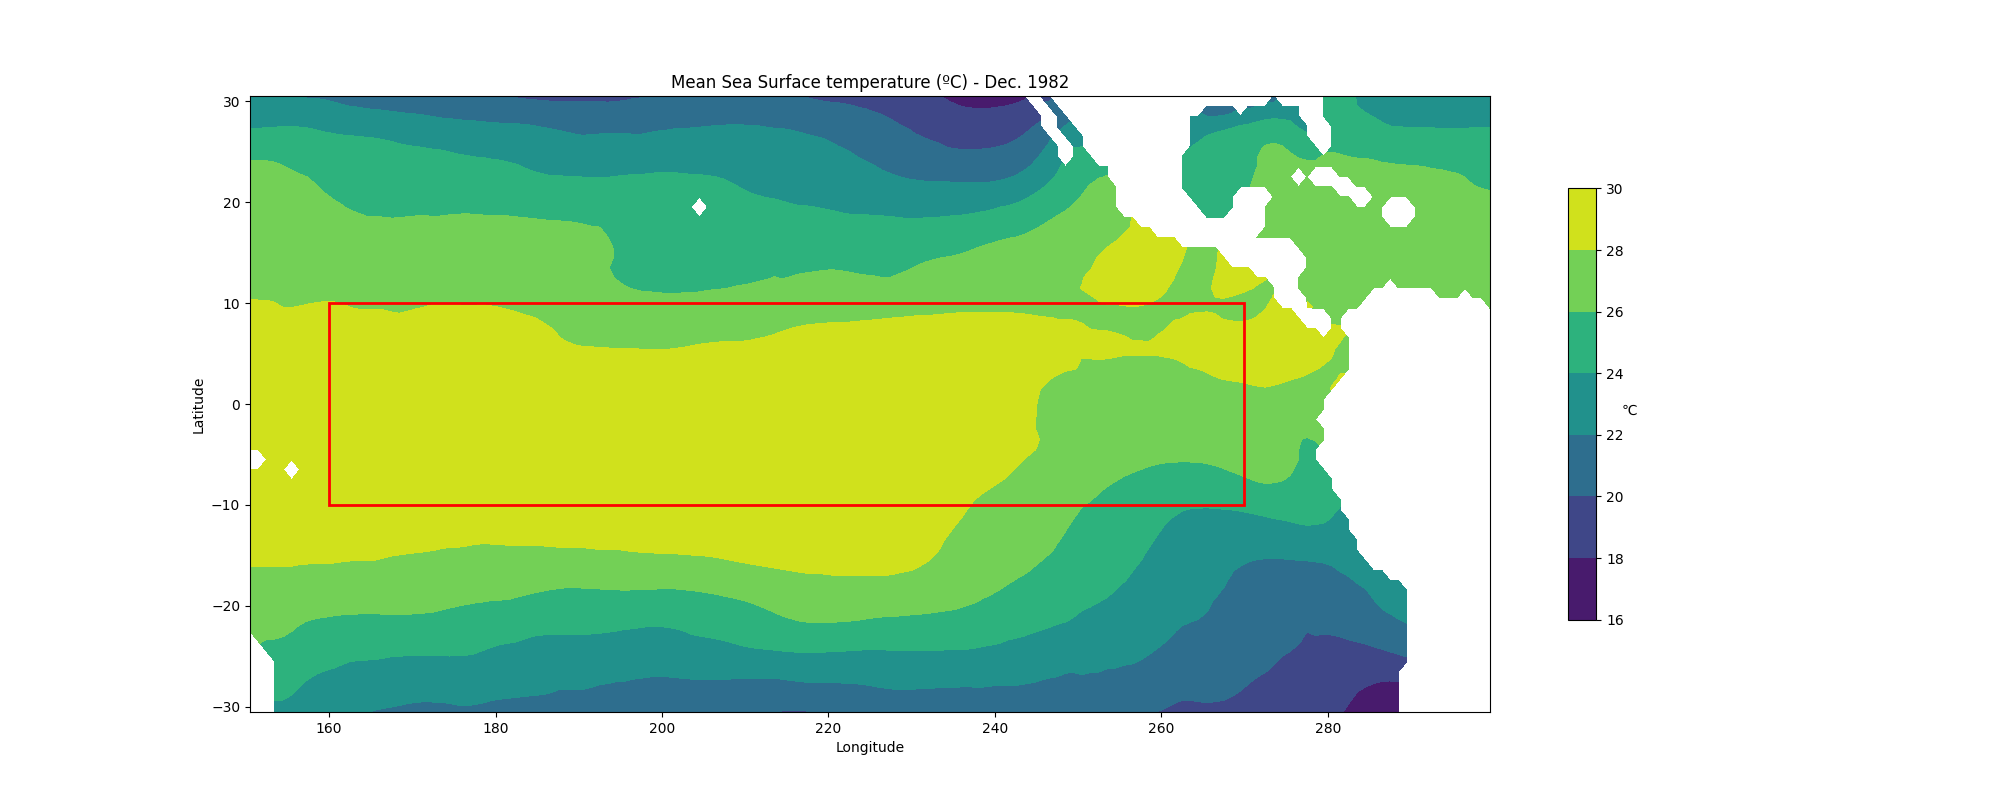

In [3]:
Image(filename='outputs/Dec._1982.png')

In [4]:
sst_34 = monthly_34_sst_avg(config.INPUT_DIR,config.FILES().csv_file)

In [5]:
sst_34.head()

,Year,Month,Anomaly (ºC)
0,1950,1,-1.62
1,1950,2,-1.32
2,1950,3,-1.07
3,1950,4,-1.11
4,1950,5,-1.37


<h2>2 - Transformation and loading process</h2>
<p>The TDA_process function performs two task:</p>
<ul>
    <li>The <a href='https://poe.com/s/CVt9fTJ73PXluwaeLO97'>sub-level set filtration</a> of each SST field</li>
    <li>The computation of the <a href='https://poe.com/s/GNsohOeUu8ZlKgfr4raI'>Euler characteristic curves</a> of each filtration</li>
</ul>

In [6]:
database = TDA_process(sst)

database.head()

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
1950_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1950_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1950_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1950_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1950_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, every SST field, which is taken as a surface will be reduced into a curve thanks to the TDA process.

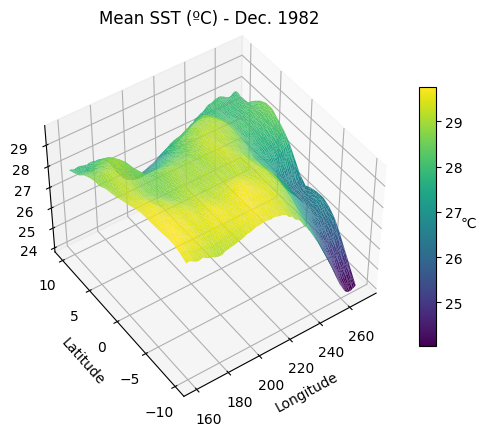

In [7]:
sst_field_plot(sst,1982,12)

<p>The outputs of the TDA_process function are curves, like the one shown below, that summarize the topological information of the surface displayed above.</p>

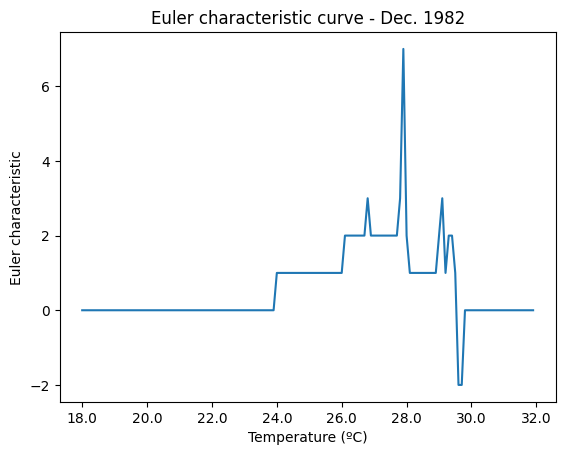

In [8]:
ecc_plot(database,1982,12)

<hr>

<p>The ONI function takes the sst_34 dataframe and computes the <a href='https://www.climate.gov/news-features/understanding-climate/climate-variability-oceanic-ni%C3%B1o-index'>Oceanic Niño Index (ONI)</a> to then place the ouputs in the <em>enso_info</em> dataframe as a new column.</p>
<p>Specifically, the ONI function assigns a numerical label to each row of the dataframe depending on the ESNO phase that corresponds to that particular month. These labels are:</p>
<ul>
    <li>Niña: 0</li>
    <li>Normal conditions: 1</li>
    <li>Niño: 2</li>
</ul>

In [9]:
enso_info = ONI(sst_34)

enso_info.head()

,Year,Month,Anomaly (ºC),Phase
0,1950,1,-1.62,0
1,1950,2,-1.32,0
2,1950,3,-1.07,0
3,1950,4,-1.11,0
4,1950,5,-1.37,0


<h2>3 - Preprocessing stage</h2>

<p>There are two previous considerations before apply the SVM which are related to unbalances data and the distributions of the ENSO events with respect to the SST. A histogram of the different ENSO phases shows that the data is unbalanced with respect to the normal conditions, which occurs arround 1.5 times more than the other events.</p>

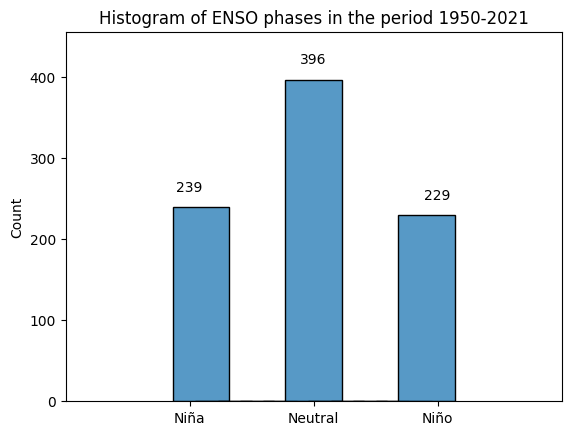

In [10]:
phases_histo(enso_info)

<p>The other issue is that there are a regions where neutral phases and the other phases occurs whith the same SSTA, so this may obstruct the task of the classifier.</p>

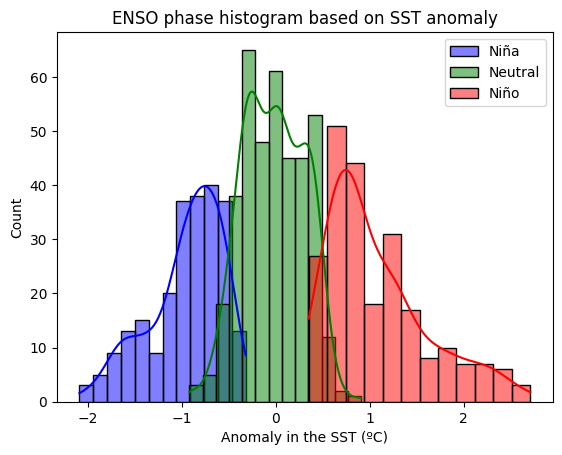

In [11]:
phases_vs_sst(enso_info,target_names = ['Niña', 'Neutral', 'Niño'])

In [12]:
boundaries=events_boundaries(enso_info)

Neutro interval = [ -0.92 , 0.91 ] 
Niña max. = -0.32  
Niño min. = 0.35


<p>It was found that -0.32ºC was the highest SSTA where a Niña event took place, the range of neutral phases is from -0.92ºC to 0.91ºC, and the lower bound of Niño events is under a SSTA of 0.35ºC.</p>

<p>To tackle this, three strategies will be applied. One of those is to consider every event that took place below a SSTA of -0.32ºC as Niña events and as Niño event to all those that took place from 0.35ºC of SSTA and on. The other strategy is to reduce the number of neutral events but respecting its actual distribution and respect the threshold given. Finally, maintaining the reduced distribution, two new lables are added:</p>

- Negative transition: -0.92ºC $\leq$ SSTA $\leq$ -0.32ºC
- Positive transition: 0.35ºC $\leq$ SSTA $\leq$ 0.91ºC

The first and the last strategy are based on the fact that the events are labeled with respect to the SSTA in the following categories:
 
- Weak: 0.5ºC $\leq$ |SSTA| $\leq$ 0.9ºC
- Moderate: 1.0ºC $\leq$ |SSTA| $\leq$ 1.4ºC
- Strong: 1.5 $\leq$ |SSTA| $\leq$ 1.9ºC
- Very Strong: 2.0ºC $\leq$ |SSTA|

So this two strategies are working mainly over weak events.

<h3>3.1 - Relabeling neutral events</h3>

<p>In this section, the preprocessing for the first strategy will be done. Here, given the historical records, the neutral events will be considered as Niña or Niño by the following conditions:</p> 

- Niña: SSTA $\leq$ -0.32ºC
- Neutral: -0.32ºC < SSTA < 0.35ºC
- Niño:  0.35ºC $\leq$ SSTA

In [13]:
relabel_enso = relabel(enso_info)

<p>This new disrtibution of events is also unbalanced, but differencence is not accentuated as the views in the first distribution, so the dataset will suffer no more changes.</p>

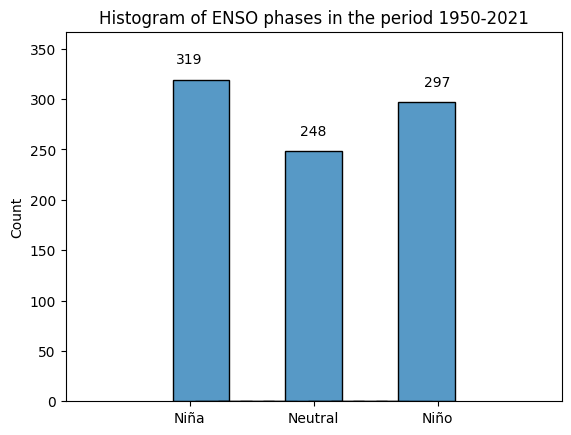

In [14]:
phases_histo(relabel_enso)

<h3>3.2 - Reshaping the distribution of phases</h3>

<p>In order to balance the dataset, what is proposed is to cluster the dataset into five categories:</p>
<ul>
    <li>ln: Low negative</li>
    <li>un: Upper negative</li>
    <li>c: Center</li>
    <li>lp: Low positive</li>
    <li>up: Upper positive</li>
</ul>

In [15]:
neutral_index, enso_info_strat, neutral_index_strat, database_strat = stratifier(database, enso_info)

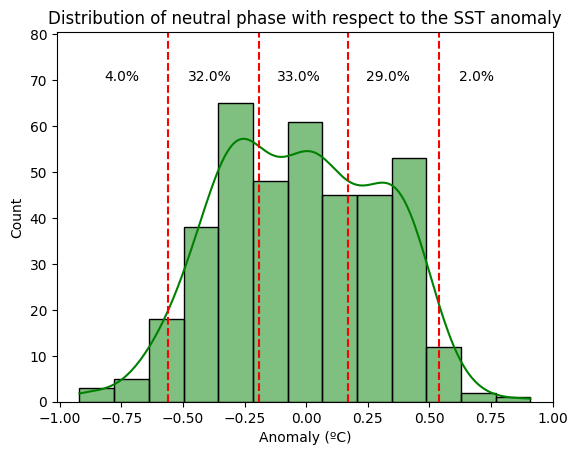

In [16]:
neutro_distribution(enso_info,neutral_index)

<p>Now that the distribution is known, the neutral phases records will be downscaled from 396 to 233, which is the average number of extreme events and it represents around the 59% of the months with normal conditions.</p>

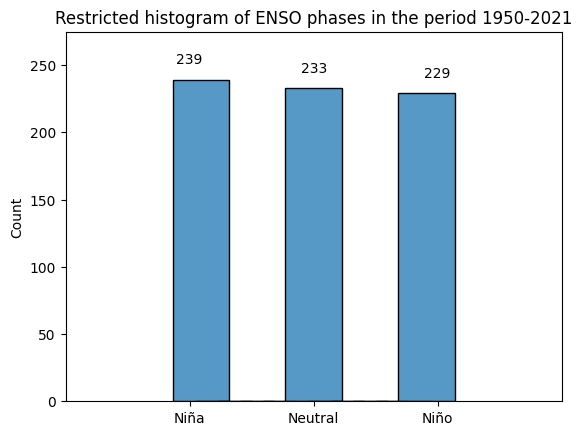

In [17]:
phases_histo(enso_info_strat,kind='restricted')

<p>In the following plot can be seen that volume of data is lower but the distribution of events has just merely changed.</p>

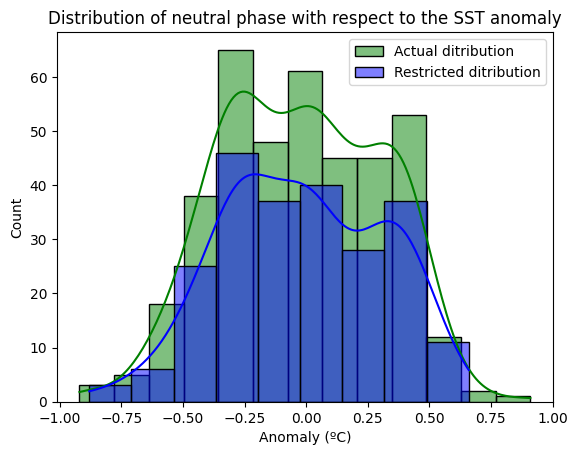

In [18]:
compared_histo(enso_info, enso_info_strat, neutral_index, neutral_index_strat)

<h3>3.3 - Adding two classes to the dataset</h3>

In [19]:
ext_enso_info = add_labels(enso_info_strat)

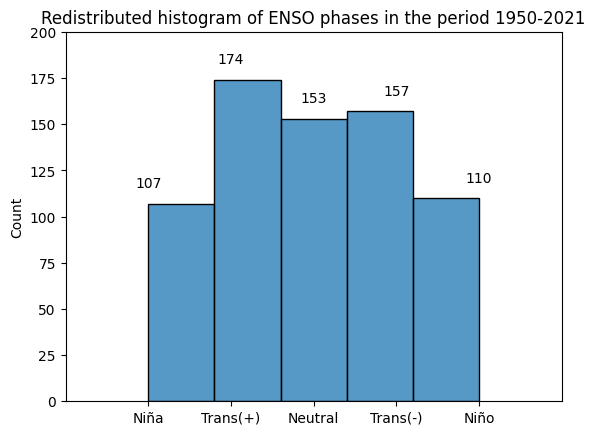

In [20]:
phases_histo_red(ext_enso_info)

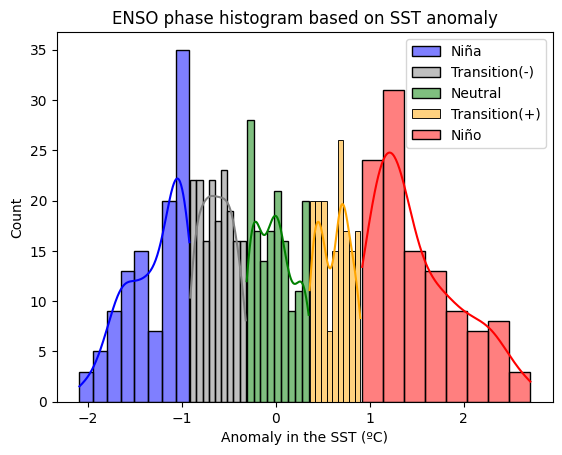

In [21]:
phases_vs_sst(ext_enso_info,target_names=['Niña','Transition(-)','Neutral','Transition(+)','Niño'])

<h2>4 - Applying the SVM algorithm</h2>

<p>Here are exposed all that is related to the model. Two versions of the SVM are propoused, polynomials and non polynomials. The data will be standarized before training the models and a GridSearch will be applied in order to arrive to the best posible models. More over, cross validation is used to improve the training process.</p>

In [22]:
model = svm.SVC()

In [23]:
scaler = StandardScaler()

In [24]:
poly_param_grid = dict(
    kernel = ['poly'], 
    degree=[1,2,3,4,5], 
    C=[1,2,3,4,5])

In [25]:
non_poly_param_grid = dict(
    kernel = ['rbf', 'sigmoid'],
    C=[1,2,3,4,5],
    gamma=['scale', 'auto'] + list(np.logspace(-3, 0, 4)))

In [26]:
cv = KFold(n_splits=20, random_state=2, shuffle=True)

In [27]:
poly_grid = GridSearchCV(estimator=model, param_grid=poly_param_grid, n_jobs=-2, cv=cv)

In [28]:
non_poly_grid = GridSearchCV(estimator=model, param_grid=non_poly_param_grid, n_jobs=-2, cv=cv)

<h3>4.1 - Testing the sensitivity of the model</h3>
<p>The first step is to verify how sensitive is the classifier discriminating the topological descriptors of the opposite events (Niña and Niño phases).</p>
<p>These first blocks of code set the configuration of the model. Here two model will be proposed, one polinomial and other non-polinomial.</p>

<h4>Preparing the data</h4>

In [29]:
mask = list((enso_info['Phase']==0) | (enso_info['Phase']==2))

LN_EN_database = database[mask]

labels = enso_info[mask]['Phase']

In [30]:
train_X, test_X, train_Y, test_Y = train_test_split(LN_EN_database, labels, test_size=40, random_state=0, shuffle=True)

In [31]:
train_X = scaler.fit_transform(train_X)

test_X = scaler.transform(test_X)

<h4>Searching the best polynomical model</h4>

In [32]:
final_model = poly_grid.fit(train_X, train_Y)

In [33]:
# summarize results
print("The best score is: %f with the following hyperparameters %s" % (final_model.best_score_, final_model.best_params_))

The best score is: 0.864286 with the following hyperparameters {'C': 5, 'degree': 2, 'kernel': 'poly'}


In [34]:
y_hat = final_model.predict(test_X)

In [35]:
print(classification_report(y_hat, test_Y))

              precision    recall  f1-score   support

           0       0.84      0.73      0.78        22
           2       0.71      0.83      0.77        18

    accuracy                           0.78        40
   macro avg       0.78      0.78      0.77        40
weighted avg       0.78      0.78      0.78        40



<h4>Searching the best non-polynomical model</h4>

In [36]:
final_model = non_poly_grid.fit(train_X, train_Y)

In [37]:
print("The best score is: %f with the following hyperparameters %s" % (final_model.best_score_, final_model.best_params_))

The best score is: 0.899567 with the following hyperparameters {'C': 4, 'gamma': 'scale', 'kernel': 'rbf'}


In [38]:
y_hat = final_model.predict(test_X)

In [39]:
print(classification_report(y_hat, test_Y))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87        20
           2       0.86      0.90      0.88        20

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted avg       0.88      0.88      0.87        40



<h3>4.2 - Developing a model for classify the ENSO phases</h3>
<p>Now the task is to make a model that can distinguish between the three phases of the ENSO phenomena. Again, a polynomial and non-polinomial models are proposed.</p>

<h3>4.2.1First strategy</h3>

<h4>Preparing the data.</h4>

In [40]:
train_X, test_X, train_Y, test_Y = train_test_split(database, relabel_enso['Phase'], test_size=.3, random_state=3, shuffle=True)

train_X = scaler.fit_transform(train_X)

test_X = scaler.transform(test_X)

<h4>Searching the best polynomical model</h4>

In [41]:
model = svm.SVC(decision_function_shape='ovo')

final_model = poly_grid.fit(train_X, train_Y)

In [42]:
print("The best score is: %f with the following hyperparameters %s" % (final_model.best_score_, final_model.best_params_))

The best score is: 0.596022 with the following hyperparameters {'C': 2, 'degree': 2, 'kernel': 'poly'}


In [43]:
y_hat = final_model.predict(test_X)

In [44]:
print(classification_report(y_hat, test_Y,target_names=['Niña','Neutral','Niño']))

              precision    recall  f1-score   support

        Niña       0.77      0.56      0.65       115
     Neutral       0.32      0.41      0.36        58
        Niño       0.62      0.72      0.67        87

    accuracy                           0.58       260
   macro avg       0.57      0.56      0.56       260
weighted avg       0.62      0.58      0.59       260



<h4>Searching the best non-polynomical model</h4>

In [45]:
model = svm.SVC(decision_function_shape='ovr')

final_model = non_poly_grid.fit(train_X, train_Y)

In [46]:
print("The best score is: %f with the following hyperparameters %s" % (final_model.best_score_, final_model.best_params_))

The best score is: 0.630699 with the following hyperparameters {'C': 2, 'gamma': 'auto', 'kernel': 'rbf'}


In [47]:
y_hat = final_model.predict(test_X)

In [48]:
print(classification_report(y_hat, test_Y, target_names=['Niña','Neutral','Niño']))

              precision    recall  f1-score   support

        Niña       0.77      0.64      0.70       100
     Neutral       0.28      0.41      0.33        51
        Niño       0.74      0.69      0.71       109

    accuracy                           0.62       260
   macro avg       0.60      0.58      0.58       260
weighted avg       0.66      0.62      0.63       260



<h3>4.2.2 - Second strategy</h3>

<h4>Preparing the data</h4>

In [49]:
train_X, test_X, train_Y, test_Y = train_test_split(database_strat, enso_info_strat['Phase'], test_size=.3, random_state=3, shuffle=True)

In [50]:
train_X = scaler.fit_transform(train_X)

test_X = scaler.transform(test_X)

<h4>Searching the best polynomical model</h4>

In [51]:
model = svm.SVC(decision_function_shape='ovo')

In [52]:
final_model = poly_grid.fit(train_X, train_Y)

In [53]:
print("The best score is: %f with the following hyperparameters %s" % (final_model.best_score_, final_model.best_params_))

The best score is: 0.574083 with the following hyperparameters {'C': 4, 'degree': 3, 'kernel': 'poly'}


In [54]:
y_hat = final_model.predict(test_X)

In [55]:
print(classification_report(y_hat, test_Y,target_names=['Niña','Neutral','Niño']))

              precision    recall  f1-score   support

        Niña       0.64      0.77      0.70        60
     Neutral       0.58      0.55      0.57        74
        Niño       0.75      0.66      0.70        77

    accuracy                           0.65       211
   macro avg       0.66      0.66      0.66       211
weighted avg       0.66      0.65      0.65       211



<h4>Searching the best non-polynomical model</h4>

In [56]:
model = svm.SVC(decision_function_shape='ovr')

In [57]:
final_model = non_poly_grid.fit(train_X, train_Y)

In [58]:
print("The best score is: %f with the following hyperparameters %s" % (final_model.best_score_, final_model.best_params_))

The best score is: 0.597917 with the following hyperparameters {'C': 2, 'gamma': 0.01, 'kernel': 'rbf'}


In [59]:
y_hat = final_model.predict(test_X)

In [60]:
print(classification_report(y_hat,test_Y,target_names=['Niña','Neutral','Niño']))

              precision    recall  f1-score   support

        Niña       0.79      0.72      0.75        79
     Neutral       0.52      0.61      0.56        61
        Niño       0.75      0.72      0.73        71

    accuracy                           0.69       211
   macro avg       0.69      0.68      0.68       211
weighted avg       0.70      0.69      0.69       211



<h3>4.2.3 - Third strategy</h3>

<h4>Preparing the data</h4>

In [62]:
train_X, test_X, train_Y, test_Y = train_test_split(database_strat, ext_enso_info['Phase'], test_size=.3, random_state=3, shuffle=True)

In [63]:
train_X = scaler.fit_transform(train_X)

test_X = scaler.transform(test_X)

<h4>Searching the best polynomical model</h4>

In [64]:
model = svm.SVC(decision_function_shape='ovr')

In [65]:
final_model = poly_grid.fit(train_X, train_Y)

In [66]:
print("The best score is: %f with the following hyperparameters %s" % (final_model.best_score_, final_model.best_params_))

The best score is: 0.394917 with the following hyperparameters {'C': 5, 'degree': 3, 'kernel': 'poly'}


In [67]:
y_hat = final_model.predict(test_X)

In [68]:
print(classification_report(y_hat, test_Y,target_names=['Niña','- transition','Neutral','+transition','Niño']))

              precision    recall  f1-score   support

        Niña       0.31      0.60      0.41        15
- transition       0.48      0.39      0.43        69
     Neutral       0.52      0.34      0.41        70
 +transition       0.35      0.45      0.39        38
        Niño       0.29      0.47      0.36        19

    accuracy                           0.41       211
   macro avg       0.39      0.45      0.40       211
weighted avg       0.44      0.41      0.41       211



<h3>Searching the best non-polynomical model</h3>

In [69]:
model = svm.SVC(decision_function_shape='ovr')

In [70]:
final_model = non_poly_grid.fit(train_X, train_Y)

In [71]:
print("The best score is: %f with the following hyperparameters %s" % (final_model.best_score_, final_model.best_params_))

The best score is: 0.429167 with the following hyperparameters {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


In [72]:
y_hat = final_model.predict(test_X)

In [73]:
print(classification_report(y_hat, test_Y, target_names=['Niña','- transition','Neutral','+transition','Niño']))

              precision    recall  f1-score   support

        Niña       0.41      0.50      0.45        24
- transition       0.57      0.39      0.46        83
     Neutral       0.30      0.40      0.35        35
 +transition       0.53      0.47      0.50        55
        Niño       0.32      0.71      0.44        14

    accuracy                           0.45       211
   macro avg       0.43      0.49      0.44       211
weighted avg       0.48      0.45      0.45       211

